## Importaciones

In [ ]:

from dotenv import load_dotenv
import google.generativeai as genai
import pandas as pd
import warnings
import os
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    f1_score,
    classification_report,
    multilabel_confusion_matrix,
    accuracy_score,
)
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
warnings.filterwarnings("ignore")

## Carga de datos

En este apartado se realiza la carga de datos de la competencia se crea una nueva columna `labels` donde se estructuran los valores de la columna `group`
por ejemplo:  neurologial|hepatorenal en forma de lista como ['neurological','hepatorenal']
esto con el objetivo que sea mucho mas facil hacer la clasificación multietiquetas mas adelante.

In [2]:
# Cargar CSV (usa sep=';' porque tu dataset está separado por punto y coma)
df = pd.read_csv("../data/dataset.csv", sep=";")

# Crear columna de etiquetas como listas
df["labels"] = df["group"].str.split("|")

# Lista de todas las clases únicas
all_labels = sorted(set(label for labels in df["labels"] for label in labels))
print(all_labels)

['cardiovascular', 'hepatorenal', 'neurological', 'oncological']


## Generacion de embbedings

Utilizando la API de Gemini, se emplea el modelo especializado **text-embedding-004** para generar embeddings. Con la clave de API previamente generada y configurada, se implementa una función que recibe como parámetro un texto. Este texto se construye concatenando los valores de las columnas `title` y `abstract` de cada registro.

La función envía este texto al modelo **text-embedding-004**, el cual devuelve un embedding optimizado para tareas de clasificación. Este proceso se repite para cada registro del conjunto de datos y los embeddings generados se almacenan en una nueva columna llamada embedding.

In [19]:
# Cargar variables desde .env
load_dotenv()

# Configurar Gemini con la API Key
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

In [20]:
# Función para generar embeddings con Gemini
def get_gemini_embedding(text):
    model = "models/text-embedding-004"
    if not text or not isinstance(text, str):
        return [0.0] * 768  # Tamaño del embedding para este modelo
    try:
        response = genai.embed_content(
            model=model, content=text, task_type="classification"
        )
        return response["embedding"]
    except Exception as e:
        print(f"Error generando embedding para el texto: {text[:50]}... Error: {e}")
        return [0.0] * 768

In [6]:
# Convertir a minúsculas para consistencia
label_embeddings = {label: get_gemini_embedding(label) for label in all_labels}

# Crear texto una nueva columa desde la cual se construiran los embeddings
df["text"] = df["title"].fillna("") + " " + df["abstract"].fillna("")

# construir de los embeddings de cada texto
df["embedding"] = df["text"].apply(get_gemini_embedding)

## Modelos

Una vez generados los embeddings, estos se emplean para entrenar modelos de clasificación. Tras realizar diversas pruebas, los algoritmos que obtuvieron mejores resultados fueron **LogisticRegression** y **LinearSVC**.

Para manejar el problema de clasificación multietiqueta, se utilizó **MultiLabelBinarizer**, una herramienta que transforma las etiquetas de cada texto en una representación binaria (matriz de ceros y unos), donde cada columna corresponde a una clase. Esta transformación permite que los modelos trabajen de manera eficiente con múltiples etiquetas por registro.

Posteriormente, se aplicó **OneVsRestClassifier**, que entrena un clasificador independiente por cada clase. En este esquema, cada clasificador funciona como un modelo binario encargado de predecir si un texto pertenece o no a una categoría específica.

In [24]:
X = np.array(df["embedding"].to_list(), dtype=float)

# Crear un binarizador multietiqueta usando una lista de todas las clases posibles.
mlb = MultiLabelBinarizer(classes=all_labels)

# Transformar la columna 'labels' del DataFrame en una matriz binaria.
y = mlb.fit_transform(df["labels"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [ ]:

# Usar un clasificador que soporte multietiqueta, como OneVsRest con LogisticRegression
# OneVsRest entrena un clasificador binario para cada clase, lo cual es ideal para resolver el problema
clf = OneVsRestClassifier(
    LogisticRegression(solver="liblinear", class_weight="balanced", C=150)
)

# Entrenar el modelo
clf.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = clf.predict(X_test)

In [25]:
# LinearSVC es inherentemente binario, por lo que necesita el wrapper OneVsRest
svc_clf = OneVsRestClassifier(
    LinearSVC(
        dual=True,
        random_state=42,
        max_iter=2000,
        C=16,
        tol=0.2,
        multi_class="crammer_singer",
    )
)
# Entrenar el modelo
svc_clf.fit(X_train, y_train)
# Hacer predicciones en el conjunto de prueba
y_pred = svc_clf.predict(X_test)

## Evaluacion de resultado

Una vez entrenado el modelo, se evaluó su desempeño utilizando las métricas **accuracy_score**, **f1_score (weighted)** y la **matriz de confusión**. Dado que el problema es de clasificación multietiqueta, la predicción de una etiqueta correcta no garantiza que el ejemplo esté clasificado de manera adecuada, ya que es necesario identificar correctamente todas las etiquetas correspondientes a cada muestra.  

Los resultados mostraron que, tanto con **LinearSVC** como con **LogisticRegression**, el modelo presenta indicios de **sobreajuste (overfitting)**. El análisis del **f1_score ponderado** revela un buen rendimiento en **clases mayoritarias**, mientras que las **clases minoritarias** son más difíciles de predecir. Esta tendencia se confirma en la **matriz de confusión**, donde se observa que los errores suelen presentarse cuando el modelo no logra predecir todas las etiquetas de una muestra, afectando la exactitud global.  

Entre los modelos evaluados, **LinearSVC** obtuvo el mejor desempeño general, mostrando una mayor capacidad de clasificación frente a **LogisticRegression**.  


In [10]:
# Calculo de acurracy en train
predict = svc_clf.predict(X_train)
accuracy = accuracy_score(y_train, predict)
print(f"el modelo presenta un accuracy de {accuracy:.4f}% en train")

el modelo presenta un accuracy de 0.8369% en train


In [11]:
# Calculo de acurracy en test
accuracy = accuracy_score(y_pred, y_test)
print(f"el modelo presenta un accuracy de {accuracy:.4f}% en test")

el modelo presenta un accuracy de 0.6813% en test


In [26]:
# Calcular F1-Score Ponderado (
weighted_f1 = f1_score(y_test, y_pred, average="weighted")
print(f"Métrica Principal - F1 Score Ponderado (Weighted): {weighted_f1:.4f}\n")

# Reporte de clasificación completo (muestra métricas por cada clase)
print("Reporte de Clasificación Detallado (por clase):")
# Usamos `target_names` para que el reporte muestre los nombres de las clases
print(classification_report(y_test, y_pred, target_names=all_labels))

Métrica Principal - F1 Score Ponderado (Weighted): 0.8502

Reporte de Clasificación Detallado (por clase):
                precision    recall  f1-score   support

cardiovascular       0.89      0.85      0.87       375
   hepatorenal       0.90      0.80      0.84       346
  neurological       0.85      0.86      0.85       514
   oncological       0.93      0.73      0.81       204

     micro avg       0.88      0.82      0.85      1439
     macro avg       0.89      0.81      0.85      1439
  weighted avg       0.88      0.82      0.85      1439
   samples avg       0.90      0.87      0.86      1439



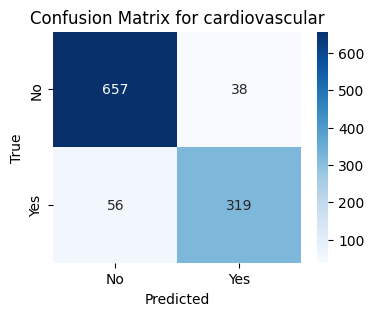

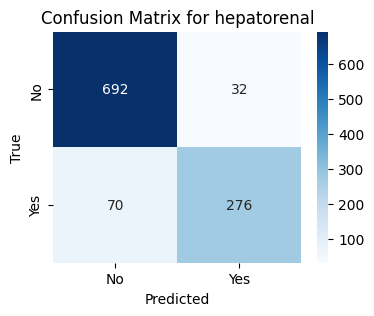

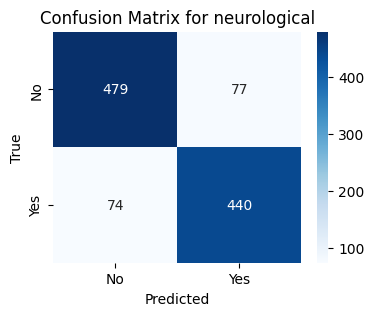

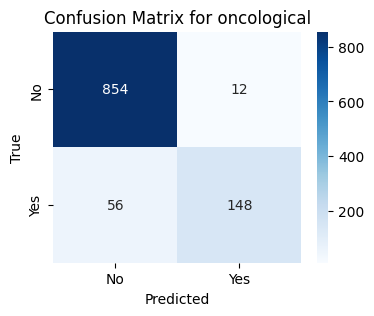

In [13]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
for i, label in enumerate(all_labels):
    cm = mcm[i]
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["No", "Yes"],
        yticklabels=["No", "Yes"],
    )
    plt.title(f"Confusion Matrix for {label}")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()

In [ ]:
y_pred=svc_clf.predict(X)
#Convertir predicciones binarias a tuplas de texto
predicted_labels_tuples = mlb.inverse_transform(y_pred)

#Unir las tuplas en un solo string separado por '|'
predicted_labels_strings = ["|".join(labels) for labels in predicted_labels_tuples]

#Crear el DataFrame de salida final
output_df = pd.DataFrame(predicted_labels_strings)
output_df = df[["title", "abstract"]].copy()
output_df["group_predicted"] = predicted_labels_strings

In [21]:
output_df["group_predicted"].value_counts()

group_predicted
neurological                               1184
cardiovascular                              686
hepatorenal                                 539
cardiovascular|neurological                 282
oncological                                 217
hepatorenal|neurological                    168
cardiovascular|hepatorenal                  146
neurological|oncological                    111
hepatorenal|oncological                      86
cardiovascular|oncological                   52
                                             41
hepatorenal|neurological|oncological         22
cardiovascular|hepatorenal|neurological      13
cardiovascular|neurological|oncological      12
cardiovascular|hepatorenal|oncological        6
Name: count, dtype: int64

In [18]:
output_df

,title,abstract,group_predicted
0,Adrenoleukodystrophy: survey of 303 cases: bio...,Adrenoleukodystrophy ( ALD ) is a genetically ...,hepatorenal|neurological
1,endoscopy reveals ventricular tachycardia secrets,Research question: How does metformin affect c...,neurological
2,dementia and cholecystitis: organ interplay,Purpose: This randomized controlled study exam...,hepatorenal
3,The interpeduncular nucleus regulates nicotine...,Partial lesions were made with kainic acid in ...,neurological
4,guillain-barre syndrome pathways in leukemia,Hypothesis: statins improves stroke outcomes v...,neurological
...,...,...,...
3560,The effect of recombinant human insulin-like g...,We recently demonstrated that recombinant hGH ...,hepatorenal
3561,EEG reveals leukemia secrets,Hypothesis: metformin improves dementia outcom...,neurological
3562,venous pathways in angina pectoris,Hypothesis: metformin improves heart disease o...,cardiovascular|neurological
3563,Thyroxine abuse: an unusual case of thyrotoxic...,Eating disorders and the associated behavioura...,neurological
